## Natural Language Processing with Disaster Tweets

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib
matplotlib.rc('font', family='AppleGothic')
matplotlib.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# 그래프 틀 변경
plt.rcParams['axes.unicode_minus'] = False
sns.set(font_scale = 1)  
plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_columns', None)

In [2]:
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
import re 
import gensim
import string

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [4]:
train = pd.read_csv('nlp-getting-started/train.csv')
test = pd.read_csv('nlp-getting-started/test.csv')

train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [5]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 있는 컬럼은: keyword 입니다
해당 컬럼에 총 61 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: location 입니다
해당 컬럼에 총 2533 개의 결측치가 존재합니다.


In [6]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


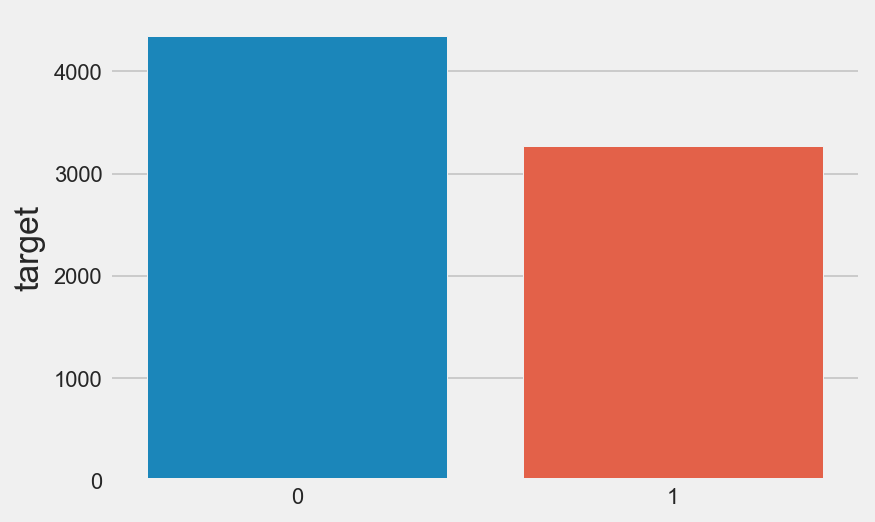

In [8]:
x = train.target.value_counts()

sns.barplot(x.index, x)
plt.show()

0(No disaster)이 1(disaster tweets) 보다 많음

### EDA

In [9]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
t_text = [r.split() for r in train['text']]
t_len = [len(t) for t in t_text]

print('문장 최대길이: {}'.format(np.max(t_len)))
print('문장 최소길이: {}'.format(np.min(t_len)))
print('문장 평균길이: {:.2f}'.format(np.mean(t_len)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(t_len)))
print('문장 중간길이: {}'.format(np.median(t_len)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 길이: {}'.format(np.percentile(t_len, 25)))
print('제 3 사분위 길이: {}'.format(np.percentile(t_len, 75)))

문장 최대길이: 31
문장 최소길이: 1
문장 평균길이: 14.90
문장 길이 표준편차: 5.73
문장 중간길이: 15.0
제 1 사분위 길이: 11.0
제 3 사분위 길이: 19.0


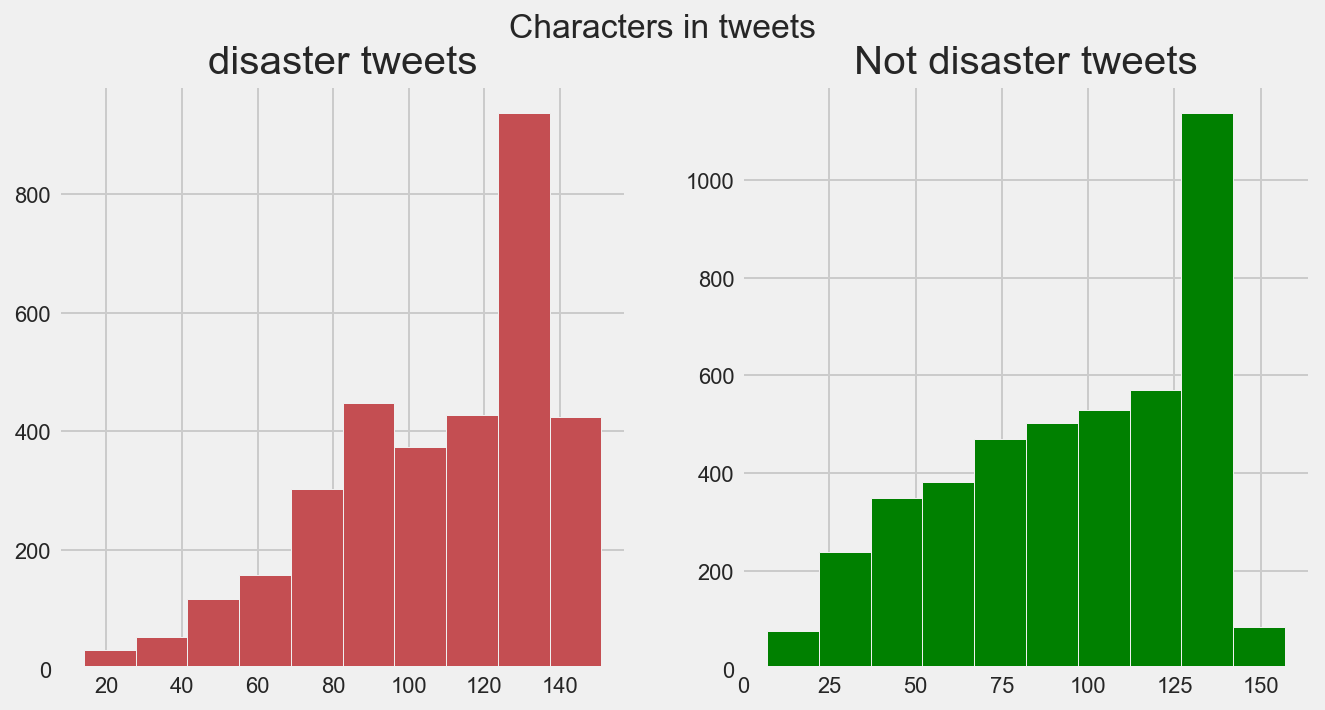

In [11]:
# Number of characters in tweets

fig , axes =plt.subplots(1,2,figsize=(10,5))

t_len=train[train['target']==1]['text'].str.len()
axes[0].hist(t_len, color = 'r')
axes[0].set_title('disaster tweets')
              
t_len= train[train['target']==0]['text'].str.len()
axes[1].hist(t_len,color='green')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

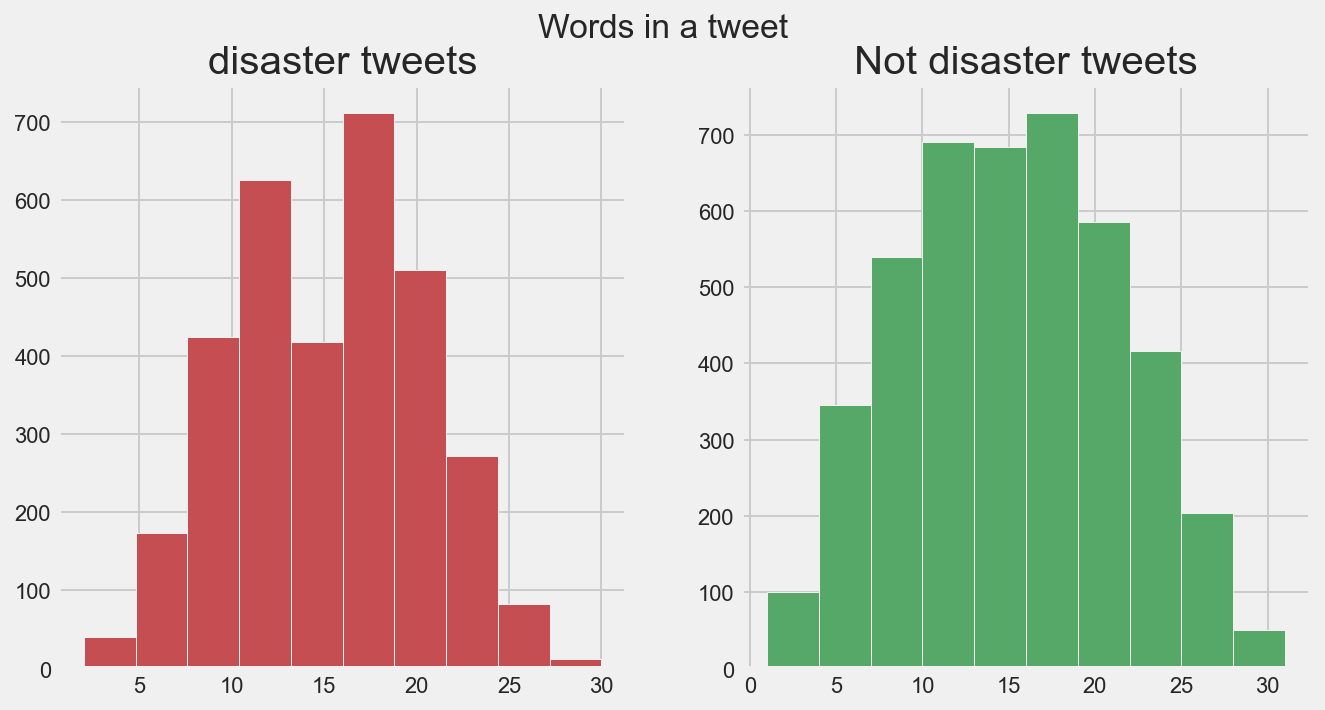

In [12]:
# Number of words in a tweet

fig, axes = plt.subplots(1,2 , figsize = (10,5))

t_len = train[train['target']==1]['text'].str.split().map(lambda x : len(x))
axes[0].hist(t_len, color = 'r')
axes[0].set_title('disaster tweets')

t_len = train[train['target']==0]['text'].str.split().map(lambda x : len(x))
axes[1].hist(t_len, color = 'g')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

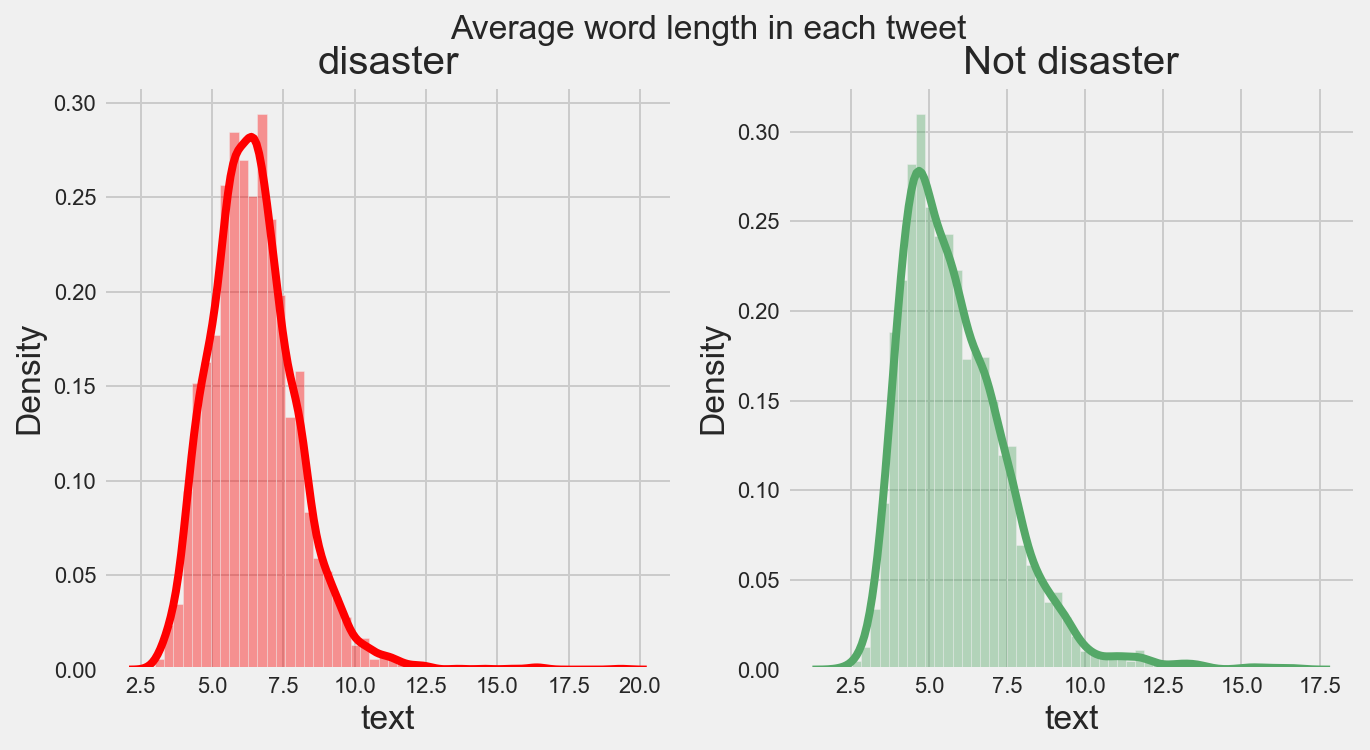

In [13]:
# Average word length in a tweet

fig, axes = plt.subplots(1,2 , figsize = (10,5))

w = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(w.map(lambda x: np.mean(x)),ax=axes[0],color='red')
axes[0].set_title('disaster')

w = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(w.map(lambda x: np.mean(x)),ax=axes[1],color='g')
axes[1].set_title('Not disaster')
fig.suptitle('Average word length in each tweet')
plt.show()

In [14]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


In [15]:
# Common stopwords in tweets

stop=set(stopwords.words('english'))

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

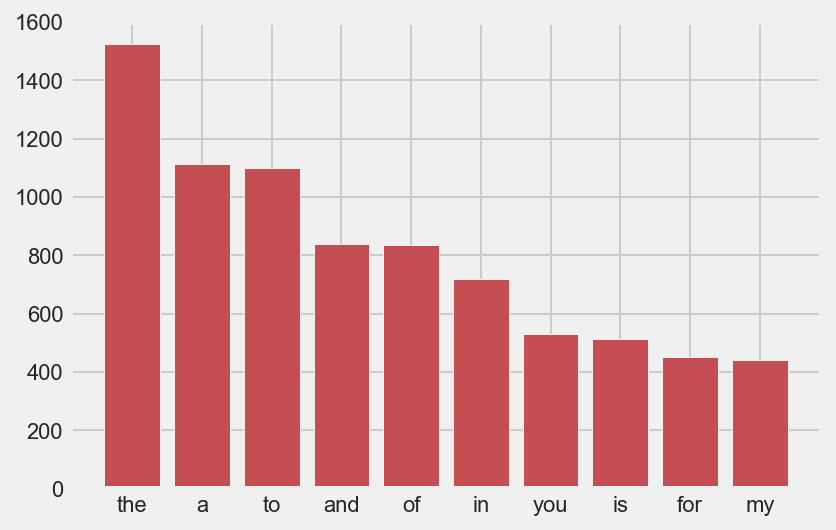

In [16]:
x,y=zip(*top)
plt.bar(x,y, color= 'r')
plt.show()

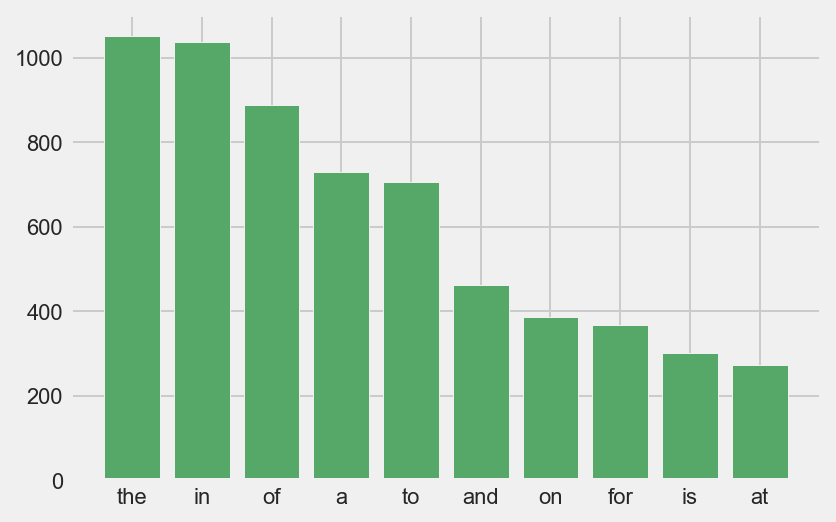

In [17]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y, color = 'g')
plt.show()

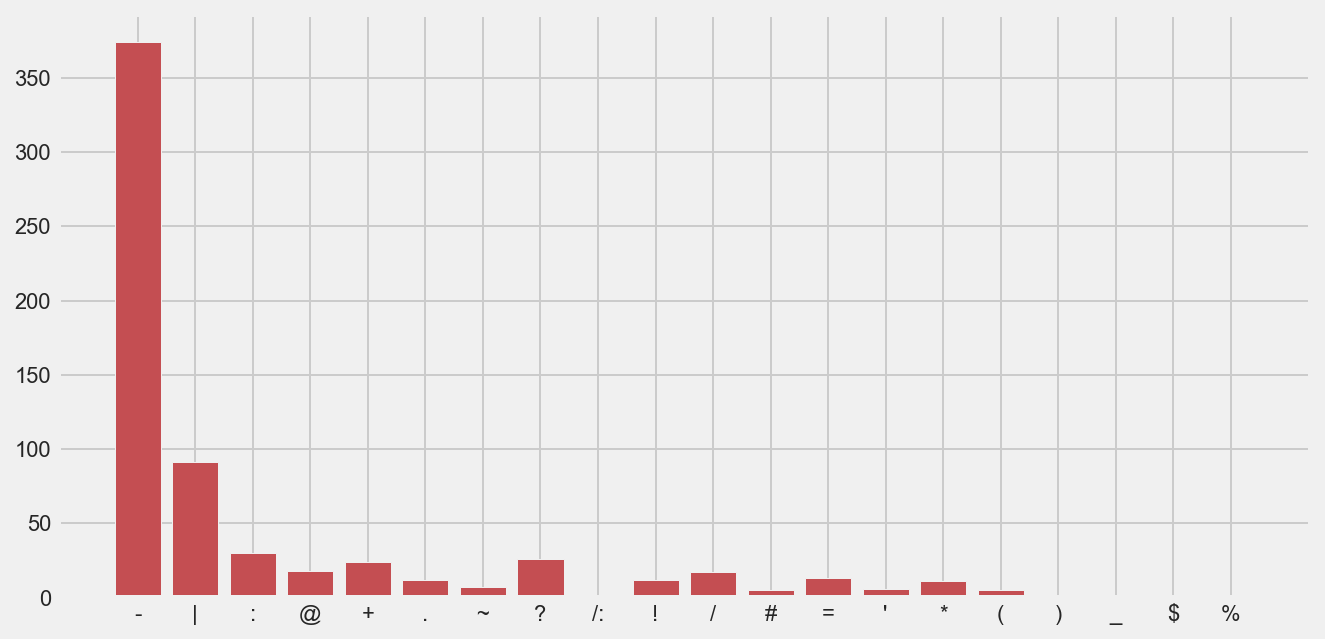

In [18]:
# Analyzing punctuations

plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color = 'r')
plt.show()

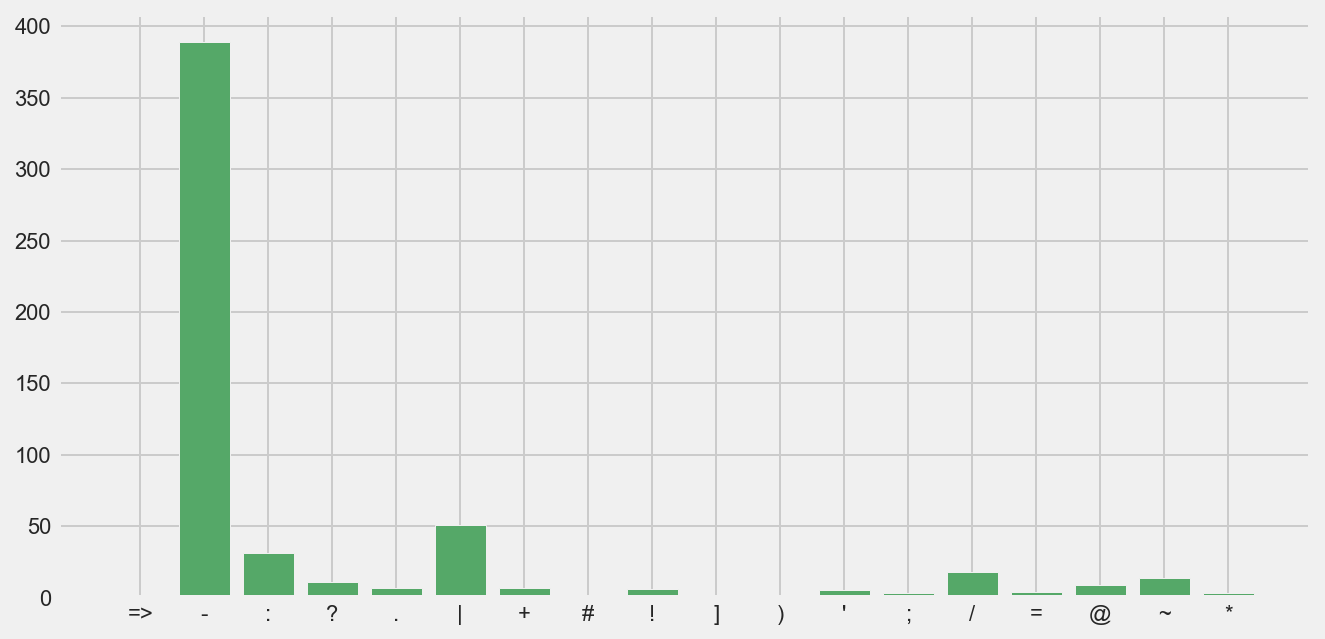

In [19]:
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='g')
plt.show()

In [20]:
# ngram 

def bigram(corpus, n= None) :
    vec = CountVectorizer(ngram_range = (2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    word_freq = sorted(words_freq, key = lambda x : x[1], reverse = True)
    
    return words_freq[:n]

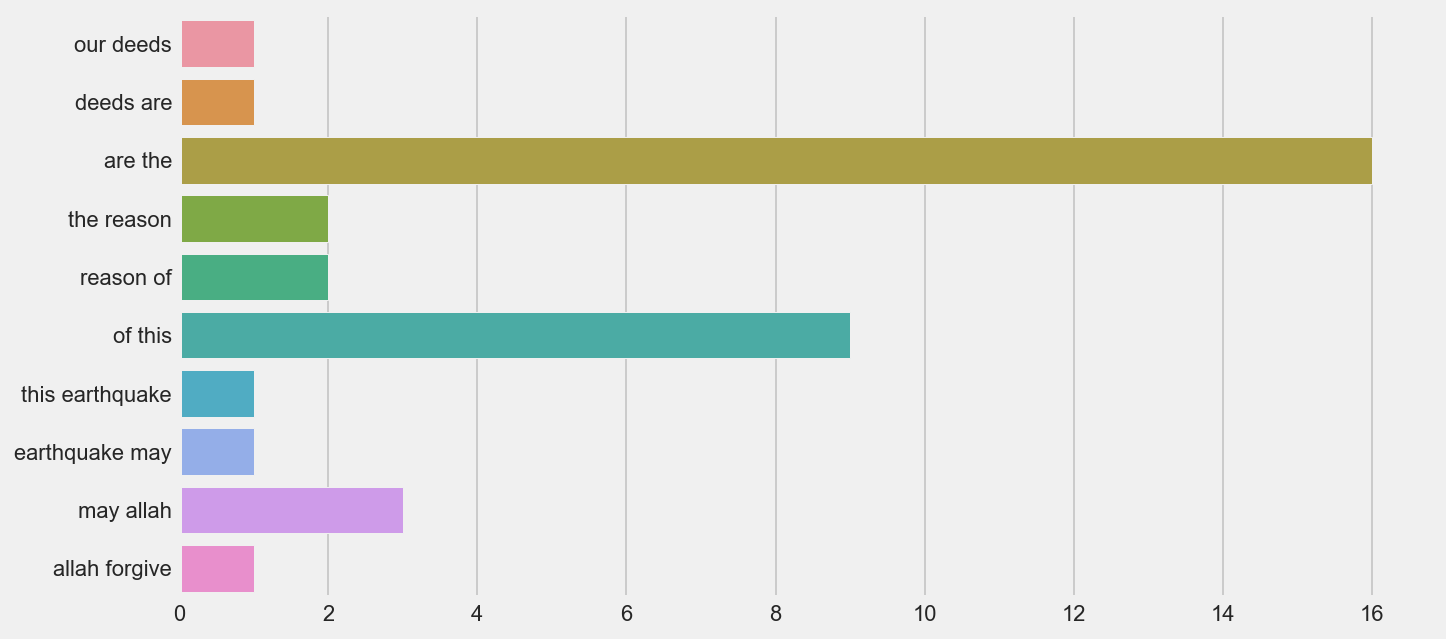

In [21]:
plt.figure(figsize = (10,5))

b = bigram(train['text'])[:10]
x,y = map(list , zip(*b))
sns.barplot(x = y, y= x)
plt.show()

## Data Cleaning 

In [22]:
data = pd.concat([train, test])

In [23]:
# url 제거 

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [24]:
data['text']  = data['text'].apply(lambda x : remove_URL(x))

In [25]:
# html tag 제거 

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [26]:
data['text']=data['text'].apply(lambda x : remove_html(x))

In [27]:
# 이모지 제거 

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [28]:
data['text']=data['text'].apply(lambda x: remove_emoji(x))

pyspellchecker 라이브러리 내의 SpellChecker 클래스를 사용하여 올바른 단어를 예측할 수 있다.   
SpellChecker 클래스 내의 correction() 함수는 철자가 틀린 단어를 입력 인수로 사용하고 수정된 단어를 문자열로 반환

In [29]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spellings(text) :
    corr_text = []
    # Returns those words that are not in the frequency list
    miss_words = spell.unknown(text.split())
    
    for word in text.split() :
        if word in miss_words :
             # Returns the most probable result for the misspelled word
            corr_text.append(spell.correction(word))
        else :
            corr_text.append(word) 
    
    return " ".join(corr_text)


text = 'banaa is fruit'

correct_spellings(text)

'banana is fruit'

In [30]:
# 시간 걸려서 패스 
# data['text'] = data['text'].apply(lambda x : correct_spellings(x))

## GloVe for Vectorization 


In [31]:
def create_corpus(data) :
    corpus= []
    for t in tqdm(data['text']) :                          # isalpha 문자인지 아닌지를 True,False로 리턴
        words=[word.lower() for word in word_tokenize(t) if((word.isalpha()==1) & (word not in stop))]
        
        corpus.append(words) 
        
    return corpus 

In [32]:
corpus = create_corpus(data)

100%|██████████| 10876/10876 [00:01<00:00, 8160.20it/s]


In [33]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [34]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [35]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 18733


In [36]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 18733/18733 [00:00<00:00, 733391.49it/s]


## Model

In [37]:
class SubClassModel(keras.Model):
    def __init__(self):
        super(SubClassModel, self).__init__()
        self.flatten = keras.layers.Flatten(input_shape=(28, 28))
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.drop = keras.layers.Dropout(0.2)
        self.dense2 = keras.layers.Dense(1, activation='softmax')
    def call(self, x, training=False):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.drop(x)
        return self.dense2(x)

In [38]:
train_=tweet_pad[:train.shape[0]]
test=tweet_pad[train.shape[0]:]

In [39]:
X_train,X_test,y_train,y_test=train_test_split(train_,train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [40]:
model = SubClassModel()

In [41]:
learning_rate = 0.001
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate),
                    loss = 'binary_crossentropy',
                    metrics =['accuracy'])

In [42]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Epoch 1/15
1618/1618 - 10s - loss: 139.6483 - accuracy: 0.4308 - val_loss: 54.8738 - val_accuracy: 0.4229 - 10s/epoch - 6ms/step
Epoch 2/15
1618/1618 - 9s - loss: 50.4966 - accuracy: 0.4308 - val_loss: 28.7866 - val_accuracy: 0.4229 - 9s/epoch - 6ms/step
Epoch 3/15
1618/1618 - 9s - loss: 28.4006 - accuracy: 0.4308 - val_loss: 20.6531 - val_accuracy: 0.4229 - 9s/epoch - 6ms/step
Epoch 4/15
1618/1618 - 10s - loss: 16.7165 - accuracy: 0.4308 - val_loss: 10.9011 - val_accuracy: 0.4229 - 10s/epoch - 6ms/step
Epoch 5/15
1618/1618 - 9s - loss: 11.6631 - accuracy: 0.4308 - val_loss: 6.1433 - val_accuracy: 0.4229 - 9s/epoch - 5ms/step
Epoch 6/15
1618/1618 - 9s - loss: 8.3363 - accuracy: 0.4308 - val_loss: 8.1495 - val_accuracy: 0.4229 - 9s/epoch - 6ms/step
Epoch 7/15
1618/1618 - 9s - loss: 4.5318 - accuracy: 0.4308 - val_loss: 2.8753 - val_accuracy: 0.4229 - 9s/epoch - 5ms/step
Epoch 8/15
1618/1618 - 8s - loss: 3.0309 - accuracy: 0.4308 - val_loss: 1.5248 - val_accuracy: 0.4229 - 8s/epoch - 5ms

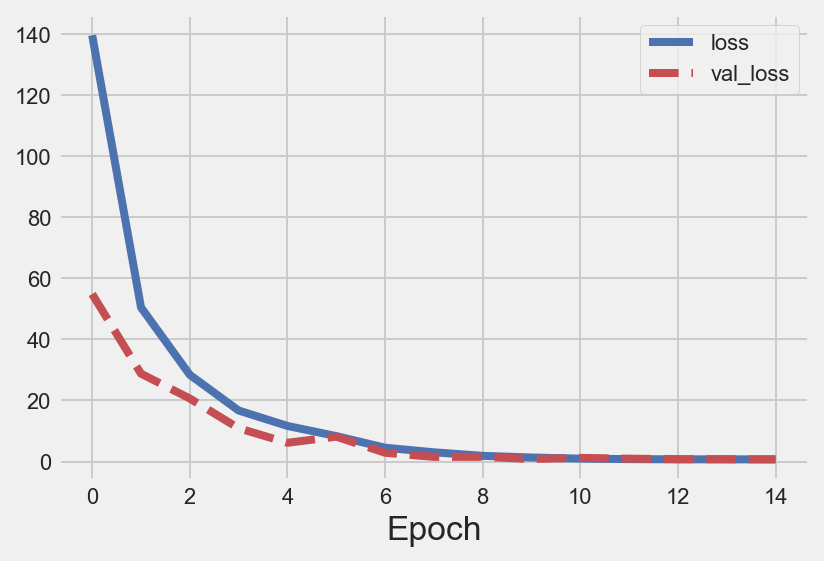

In [43]:
# plot losses 

plt.plot(history.history['loss'],'b-', label = 'loss')
plt.plot(history.history['val_loss'],'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [45]:
sample_sub=pd.read_csv('nlp-getting-started/sample_submission.csv')

In [46]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [47]:
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
